In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
class RandomWalk:
    def __init__(self, states):
        self.state_space = states
        self.action_space = 2
        self.init = self.state_space // 2
        self.player = self.init
        
    def reset(self):
        self.player = self.init
        return self.player
    
    def step(self):
        if np.random.rand() < 0.5:
            self.player -= 1
        else:
            self.player += 1
        
        if self.player == self.state_space-1:
            reward = 1
            done = True
        elif self.player == 0:
            reward = -1
            done = True
        else:
            reward = 0
            done = False
            
        return self.player, reward, done
    
    def p(self, state):
        l = []
        l.append((1/2, 1 if state + 2 == self.state_space else 0, state + 1))
        l.append((1/2, -1 if state - 1 == 0 else 0, state - 1))
        return l


In [3]:
class ValueIteration:
    def __init__(self, env, theta=0.1, gamma=1):
        self.env = env
        self.V = np.zeros(self.env.state_space)
        self.gamma = gamma
        self.theta = theta

    def iterate(self):
        done = False
        pbar = tqdm()
        while not done:
            pbar.update(1)
            new_V = np.zeros(self.env.state_space)
            for s in range(1,self.env.state_space-1):
                q = np.zeros(2)
                list = self.env.p(s)
                for (P, reward, s_p) in list:
                    new_V[s] += P * (reward + self.gamma * self.V[s_p])
            delta = np.max(np.abs(new_V - self.V))
            self.V = new_V
            if delta < self.theta:
                done = True
        pbar.close()

    def value(self):
        return self.V


In [4]:
rw = RandomWalk(21)

In [5]:
vi = ValueIteration(rw, 0.000000001, gamma=1)

In [6]:
vi.iterate()
real_values = vi.V

358it [00:00, 9609.62it/s]


In [7]:
real_values

array([ 0.        , -0.9       , -0.79999999, -0.69999999, -0.59999999,
       -0.49999999, -0.39999999, -0.29999999, -0.19999999, -0.1       ,
        0.        ,  0.1       ,  0.19999999,  0.29999999,  0.39999999,
        0.49999999,  0.59999999,  0.69999999,  0.79999999,  0.9       ,
        0.        ])

In [8]:
class nStepTD:
    def __init__(self, env, n, alpha=0.4, gamma=1):
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.n = n
        self.max_len = 10_000
        self.V = np.zeros(env.state_space)
        
    def reset(self):
        self.V = np.zeros(self.env.state_space)
        
    def estimate(self, n_episodes=1000):
        for i in range(n_episodes):
            gammas = np.power(self.gamma, range(self.max_len))
            states =[]
            rewards = []

            state = self.env.reset()
            states.append(state)

            T = np.inf
            t = 0
            while True:
                if t < T:
                    s_p, reward, done = self.env.step()
                    rewards.append(reward)
                    if done:
                        T = t + 1
                tau = t - self.n + 1
                if tau >= 0:
                    G = np.sum(gammas[:min(tau+self.n,T) - tau] * rewards[tau:min(tau+self.n,T)])
                    if tau + n < T:
                        G += np.power(self.gamma,self.n) * self.V[s_p]
                    self.V[states[tau]] += self.alpha * (G - self.V[states[tau]])
                if tau == T - 1:
                    break
                t += 1
                state = s_p
                states.append(state)
            
    def repeat(self, n_runs, n_episodes):
        avg = np.zeros(n_runs)
        for i in range(n_runs):
            self.reset()
            self.estimate(n_episodes)
            avg[i] = np.sqrt(((self.V - real_values) ** 2).mean())
        return avg.mean()
                

In [9]:
ns = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
alphas = [i * 0.1 for i in range(11)]


100%|██████████| 10/10 [05:22<00:00, 32.22s/it]


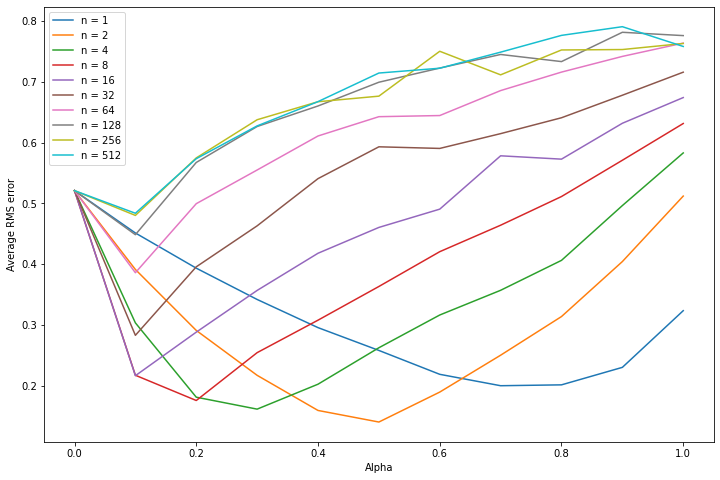

In [10]:
plt.figure(figsize=(12, 8))

for n in tqdm(ns):
    res = np.zeros(len(alphas))
    for a in range(11):
        rw = RandomWalk(21)
        td = nStepTD(rw, n, alpha=alphas[a])
        res[a] = td.repeat(100,10)
    plt.plot(alphas, res, label="n = " + str(n))
        
plt.xlabel('Alpha')
plt.ylabel('Average RMS error')
plt.legend()
plt.show()